In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.signal import find_peaks
import scipy.integrate as integrate
from scipy.signal import savgol_filter

In [2]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def variation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag_err), astro_stats.biweight_scale(mag_err)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)    


def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + 1*np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6, peak_close_rmv=15):
    
    yht = savgol_filter(dips, 11, 8) # try savgol smoothing...
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(yht, height=loc_peak_thresh, distance=500)

    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    if len(pks)>1:
        # remove peaks that are too close to each other
        t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                             t_pks[i+1],
                                                                             atol=peak_close_rmv)]) # 5 day tolerance window...

        p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                            t_pks[i+1],
                                                                            atol=peak_close_rmv)])
        srt = np.argsort(t_pks) # argsort the t_pks

        t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [3]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")

In [4]:
lc2 = ascii.read("https://ztf.snad.space/dr17/csv/802111300032579")

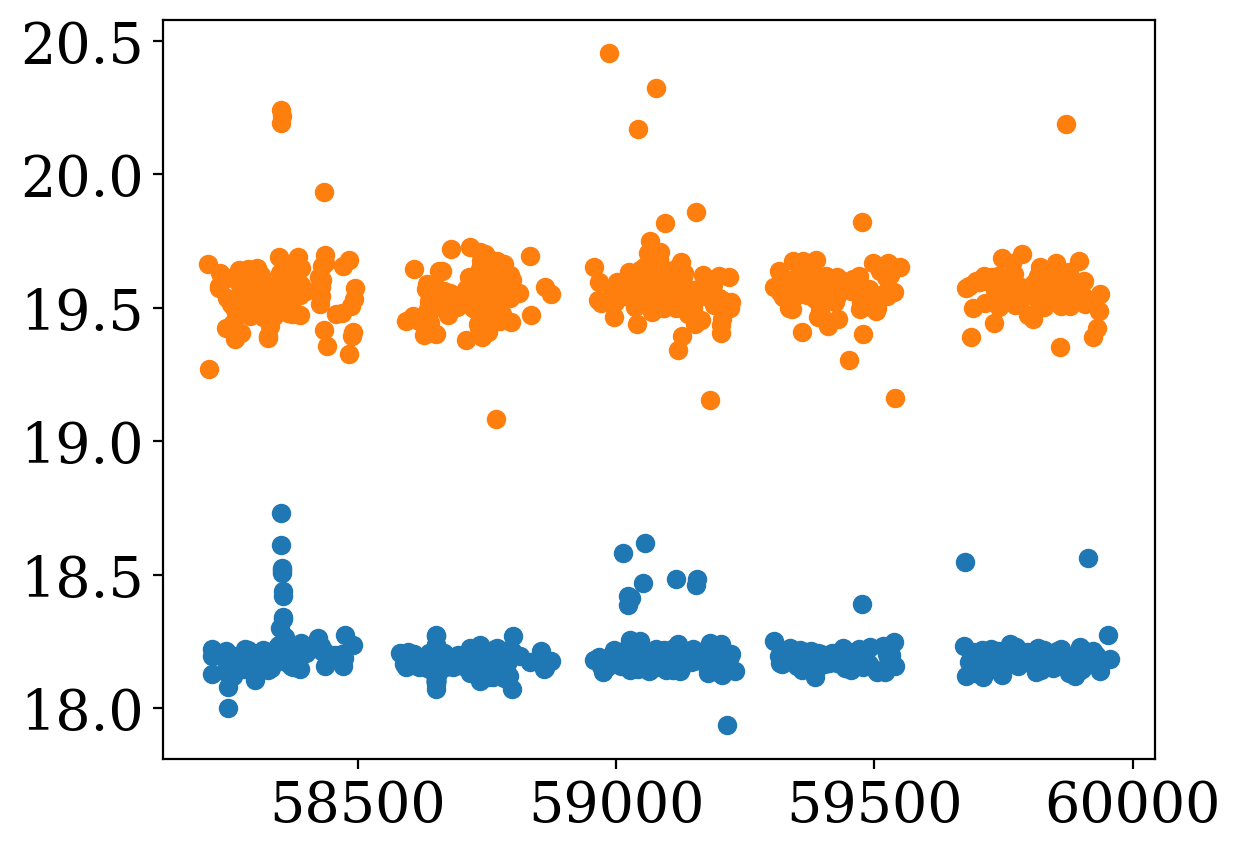

In [5]:
plt.scatter(lc['mjd'], lc['mag'])
plt.scatter(lc2['mjd'], lc2['mag'])

(1.0494570482019223, 0.972400683036842)

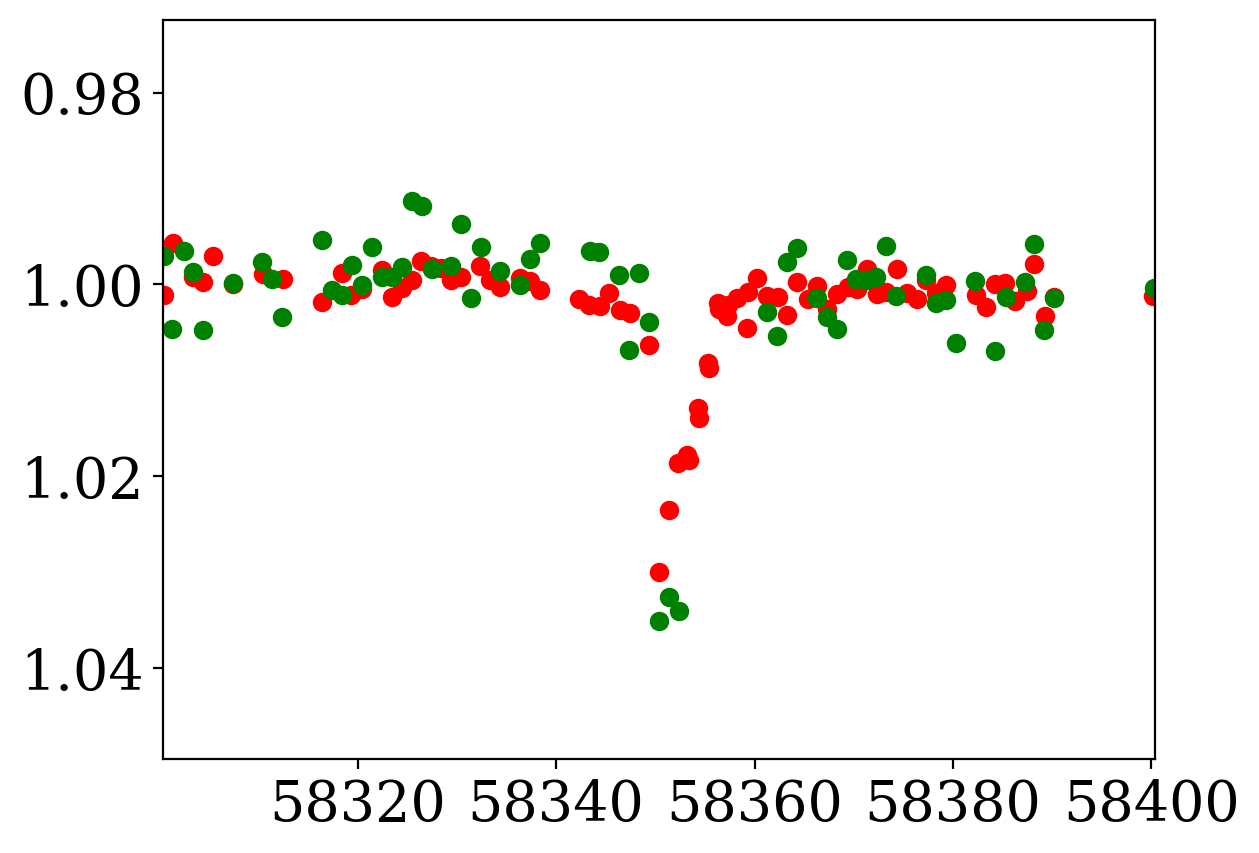

In [7]:
plt.scatter(lc['mjd'], lc['mag']/np.median(lc['mag']), color='red')
plt.scatter(lc2['mjd'], lc2['mag']/np.median(lc2['mag']), color='green')

plt.xlim(58350.3775-50, 58350.3775+50)
plt.ylim(plt.ylim()[::-1])

In [300]:
#lc = ascii.read("https://ztf.snad.space/dr17/csv/331210100140458")

In [8]:
%%time
info = summarize_dev_dips(lc['mjd'], deviation(lc['mag'], lc['magerr']), peak_close_rmv=15)

CPU times: user 16.1 ms, sys: 5.58 ms, total: 21.7 ms
Wall time: 24.3 ms


(18.771155450000002, 17.896447549999998)

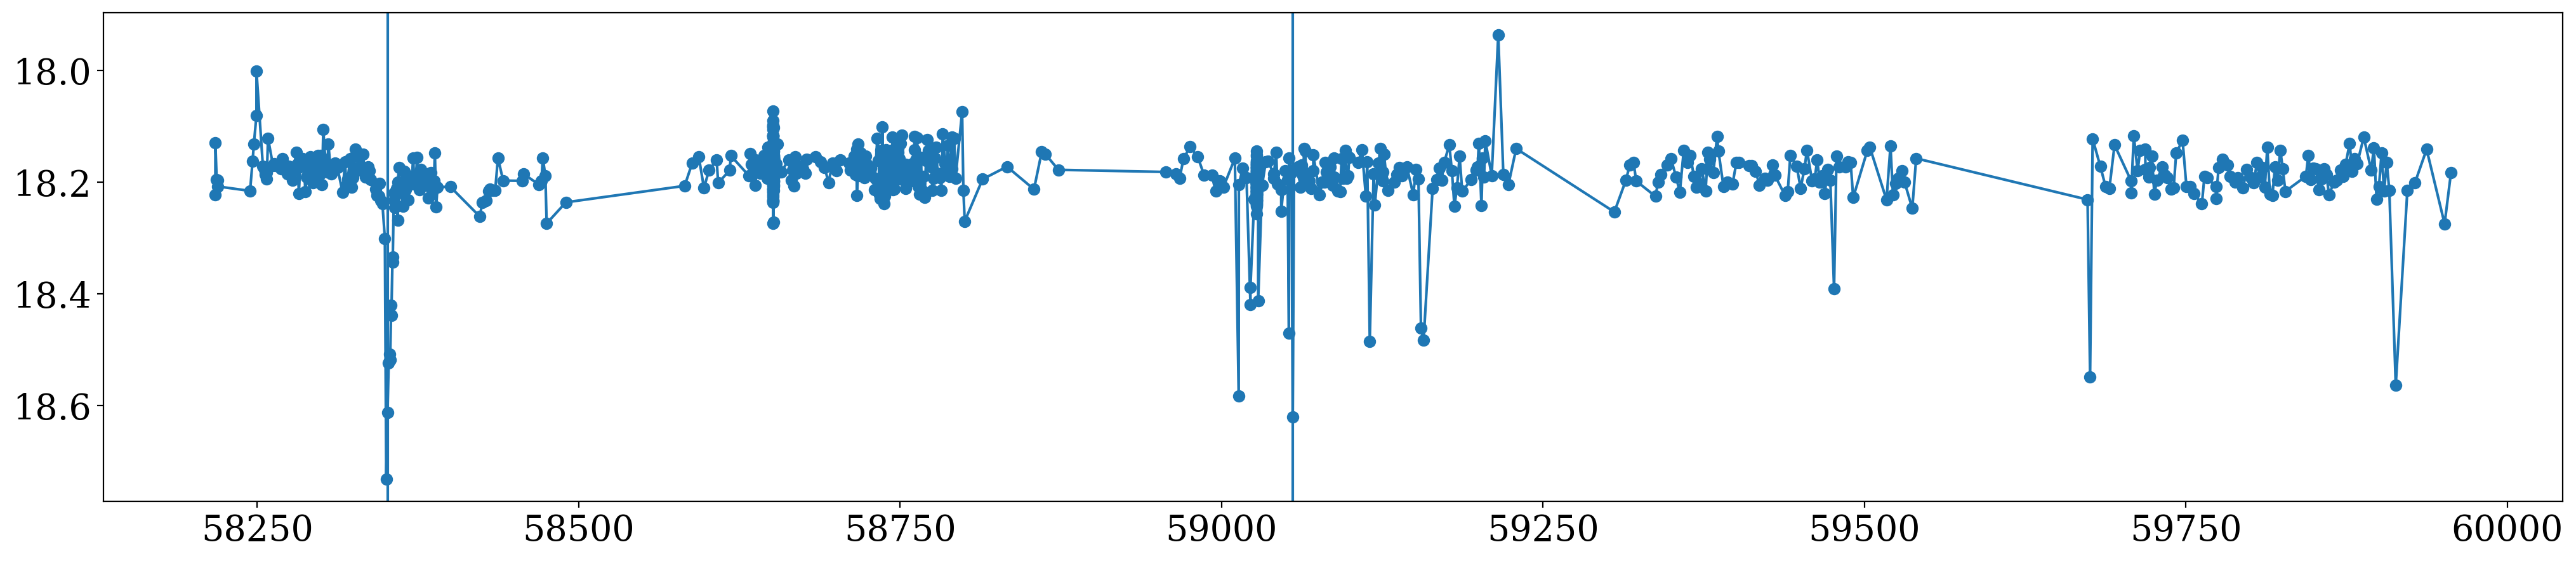

In [9]:
plt.figure(figsize=(25, 5))
for key in info[1].keys():
    ddp = info[1][key]
    
    plt.axvline(ddp['peak_loc'])
    
plt.plot(lc['mjd'], lc['mag'], 'o-')
plt.ylim(plt.ylim()[::-1])

In [10]:
info[1]

{'dip_0': {'peak_loc': 58351.36639,
  'window_start': 58364.30654,
  'window_end': 58337.33468,
  'N_1sig_in_dip': 13,
  'loc_forward_dur': 12.940149999994901,
  'dip_power': 8.918009677170696},
 'dip_1': {'peak_loc': 59055.36387,
  'window_start': 59056.39499,
  'window_end': 59054.37285,
  'N_1sig_in_dip': 1,
  'loc_forward_dur': 1.031119999999646,
  'dip_power': 9.046814172303026}}

In [11]:
info[1]['dip_0']['window_start'], info[1]['dip_0']['window_end']

(58364.30654, 58337.33468)

In [12]:
xx, yy, ee = lc['mjd'], lc['mag'], lc['magerr']

In [13]:
xs = np.where((xx>=info[1]['dip_0']['window_end']+3) & (xx<=info[1]['dip_0']['window_start']-3))

In [14]:
xx, yy, ee = xx[xs], yy[xs], ee[xs]

In [15]:
x, y, yerr = xx, yy, ee

<ErrorbarContainer object of 3 artists>

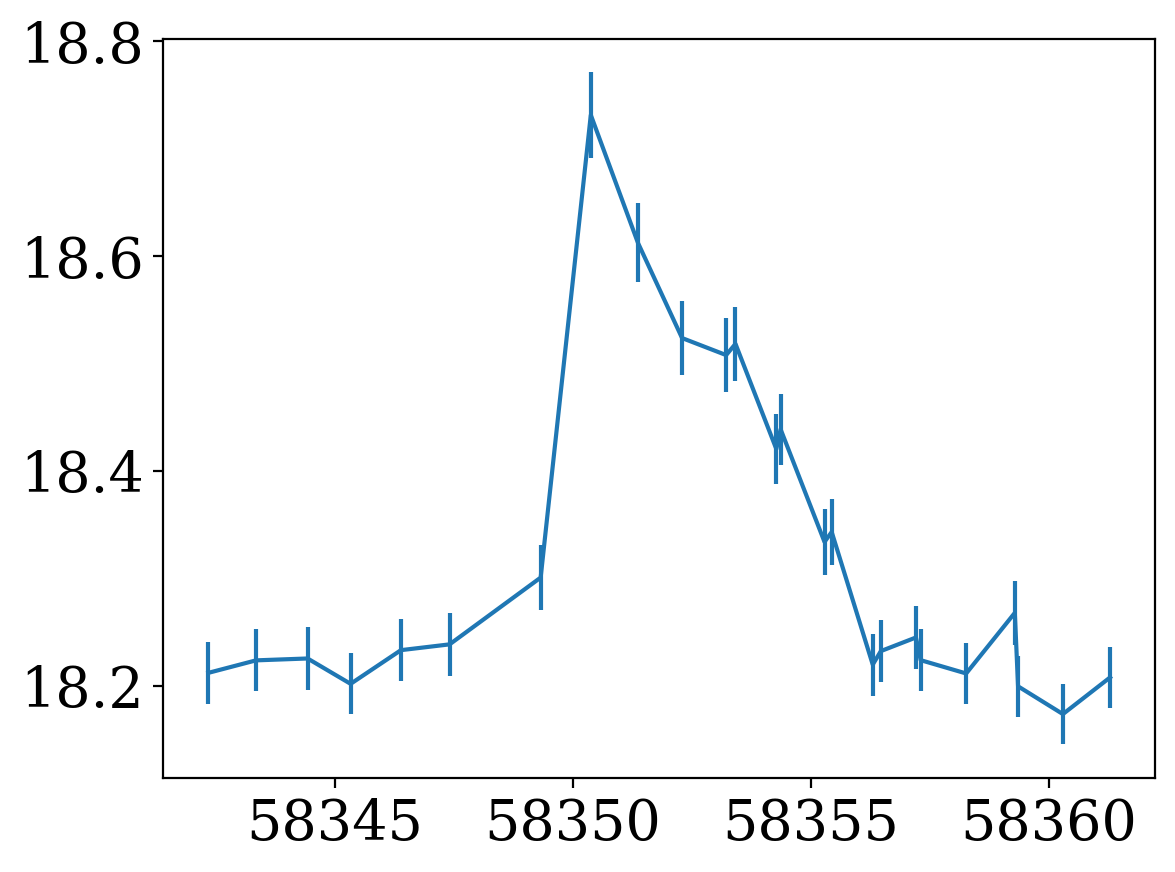

In [16]:
plt.errorbar(x, y, yerr)

In [148]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared 

In [174]:
np.argmax(y)-1

6

In [220]:
xx, yy, yerr_rr = np.delete(x, [0]), np.delete(y, [0]), np.delete(yerr, [0])

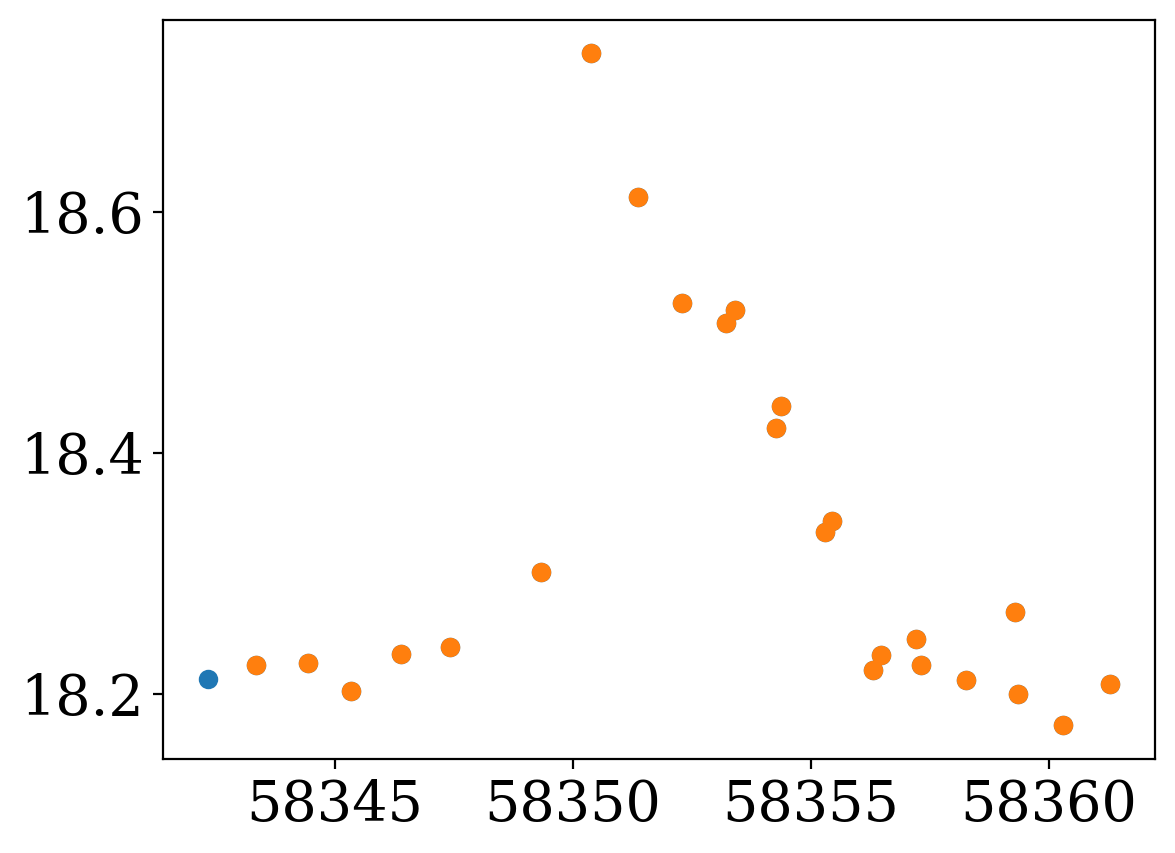

In [221]:
plt.scatter(x, y)
plt.scatter(xx, yy)


In [222]:
kernel = 1 * RBF(length_scale=0.01, length_scale_bounds=(1e-2, 1e3)) + ExpSineSquared(length_scale=0.5,
    periodicity=100,
    length_scale_bounds=(1e-05, 100000.0),
    periodicity_bounds=(1e-05, 100000.0),
)

In [223]:
noise_std = yerr_rr

In [224]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=100
)

In [225]:
gaussian_process.fit(xx.reshape(-1, 1), yy)

X = np.linspace(min(xx), max(xx), 2_000)

# predict my work 
mean_prediction, std_prediction = gaussian_process.predict(X.reshape(-1, 1), return_std=True)

/Users/andytzanidakis/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/andytzanidakis/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


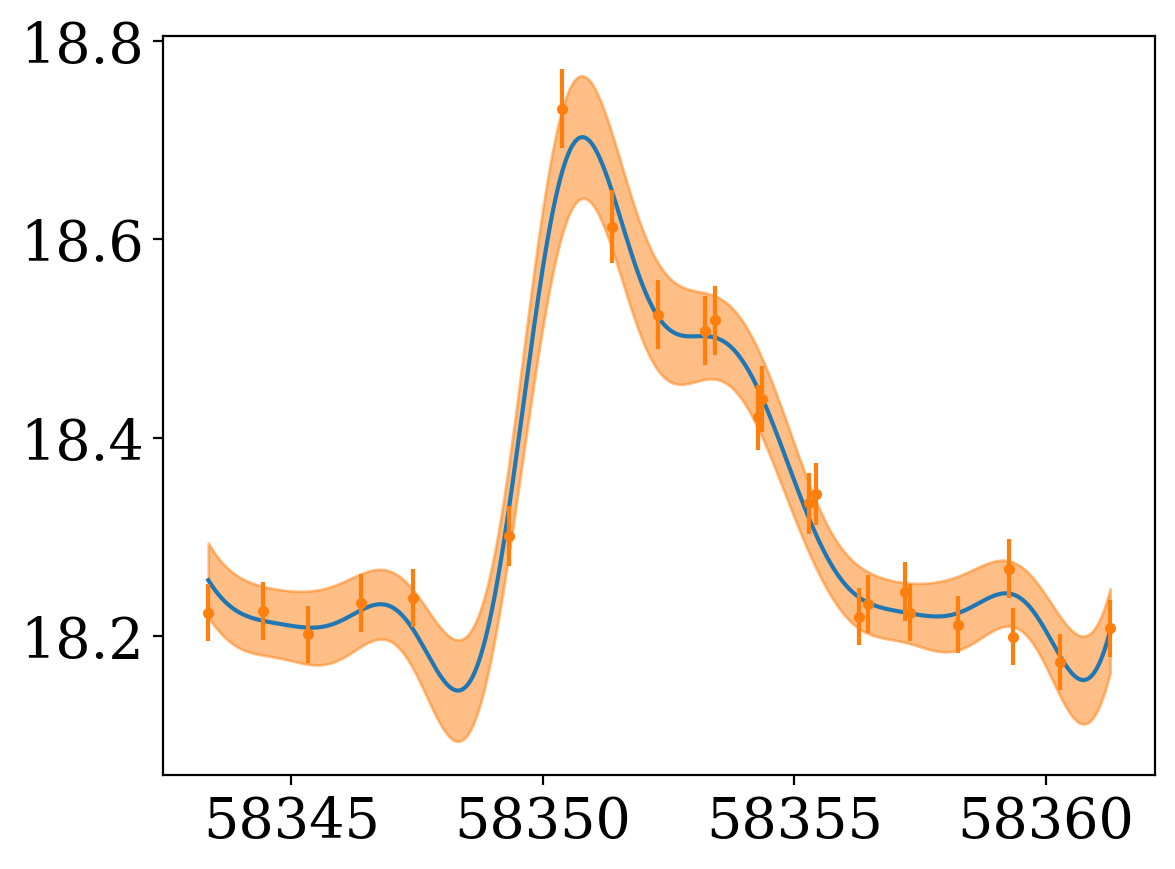

In [226]:
plt.plot(X.reshape(-1, 1), mean_prediction, label="Mean prediction")
plt.errorbar(xx, yy, yerr_rr, fmt='.')

plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)

In [82]:
from george import kernels
import george

#kernel = kernels.RationalQuadraticKernel(0.1, 100)
a, l, g, p = .1, 20, 0.01, 1
kernel =  * kernels.ExpSquaredKernel(0.01)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(min(x), max(x), 1500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

SyntaxError: can't use starred expression here (555961162.py, line 6)

<ErrorbarContainer object of 3 artists>

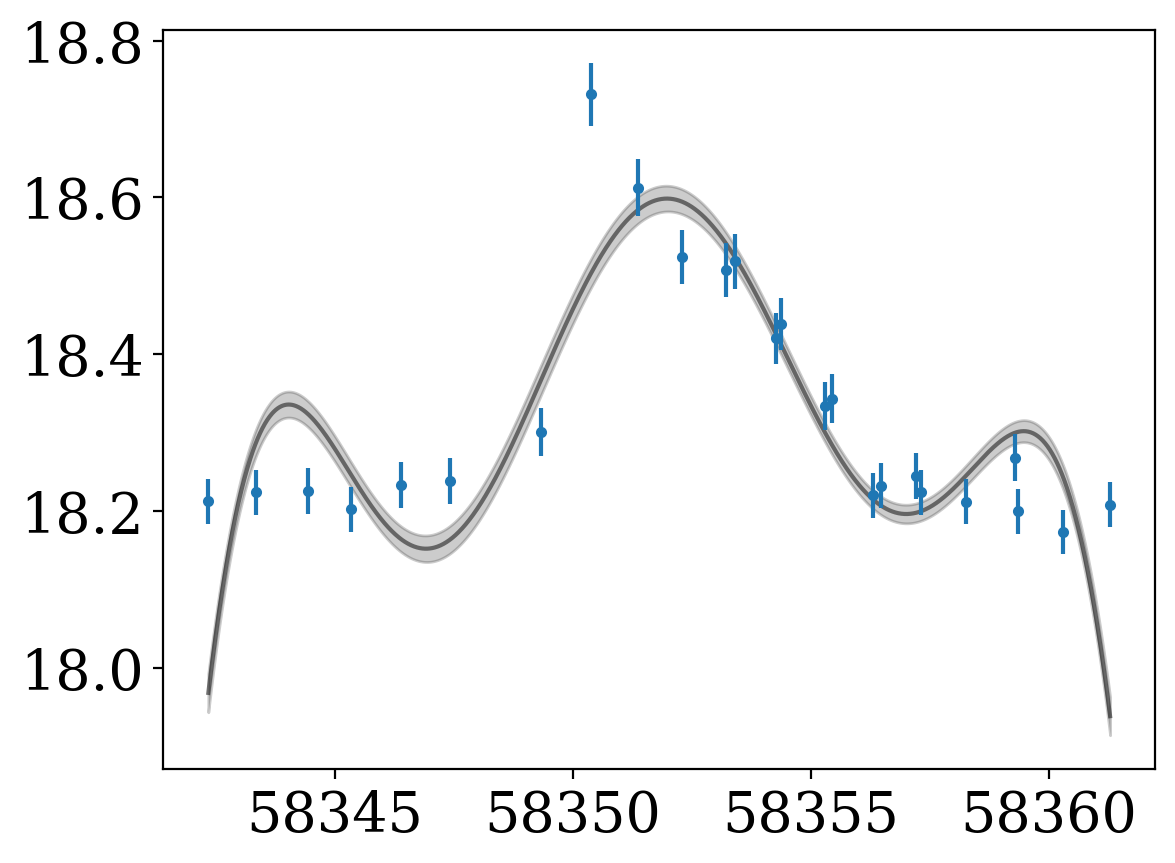

In [83]:
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x,y, yerr=yerr, fmt='.')

In [330]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))


Initial ln-likelihood: -252.12


In [331]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 145.32713600789037
 hess_inv: array([[0.22290488, 0.09278379],
       [0.09278379, 0.40354648]])
      jac: array([3.87614648e-07, 4.50697705e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([-5.63402233,  4.41914842])

Final ln-likelihood: -145.33


(18.80246915275, 18.114367832249997)

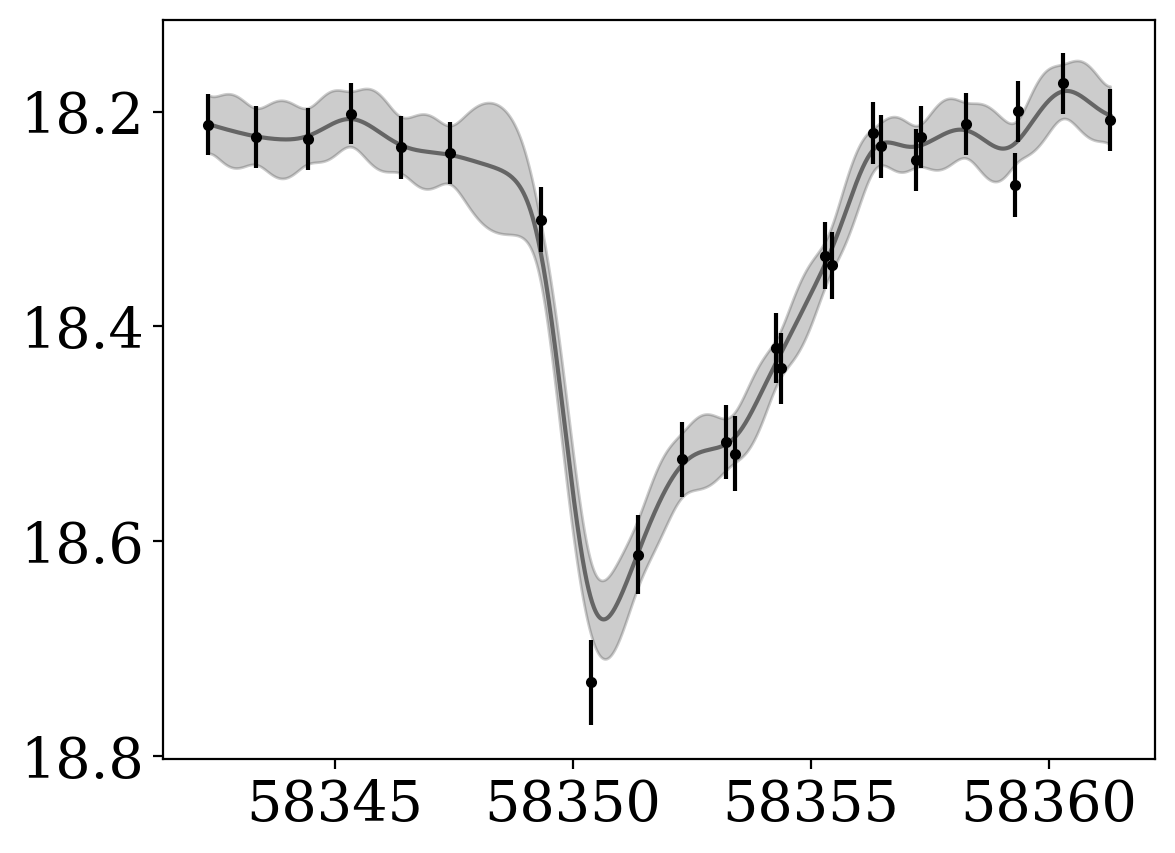

In [332]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

plt.ylim(plt.ylim()[::-1])

In [333]:
def gp_my_dip(x, y, yerr):
    kernel = kernels.RationalQuadraticKernel(log_alpha=0.5, metric=100)
    gp = george.GP(kernel)
    gp.compute(x, yerr)

    x_pred = np.linspace(min(x), max(x), 5_500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    
    init_log_L = gp.log_likelihood(y)
    
    from scipy.optimize import minimize

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)

    gp.set_parameter_vector(result.x)
    
    final_log_L = gp.log_likelihood(y)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    
    return x_pred, pred, pred_var, {"init_log_L": init_log_L, 
                                   "final_log_L": final_log_L, 
                                   "success_status":result['success']}

In [334]:
gp_my_dip(x, y, yerr)

(array([58342.34553   , 58342.34897353, 58342.35241705, ...,
        58361.27459295, 58361.27803647, 58361.28148   ]),
 array([18.21153948, 18.21158793, 18.2116363 , ..., 18.20332957,
        18.203388  , 18.20344561]),
 array([0.00074057, 0.00073795, 0.00073552, ..., 0.00073081, 0.00073329,
        0.00073597]),
 {'init_log_L': -271.5923295460587,
  'final_log_L': -145.32713600788918,
  'success_status': True})

In [335]:
lc_new = ascii.read("https://ztf.snad.space/dr17/csv/331210100140458")

In [336]:
lc_new = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")

In [337]:
inf = summarize_dev_dips(lc_new['mjd'], deviation(lc_new['mag'], lc_new['magerr']))

In [338]:
inf

(2,
 {'dip_0': {'peak_loc': 58351.36639,
   'window_start': 58364.30654,
   'window_end': 58337.33468,
   'N_1sig_in_dip': 13,
   'loc_forward_dur': 12.940149999994901,
   'dip_power': 8.918009677170696},
  'dip_1': {'peak_loc': 59055.36387,
   'window_start': 59056.39499,
   'window_end': 59054.37285,
   'N_1sig_in_dip': 1,
   'loc_forward_dur': 1.031119999999646,
   'dip_power': 9.046814172303026}})

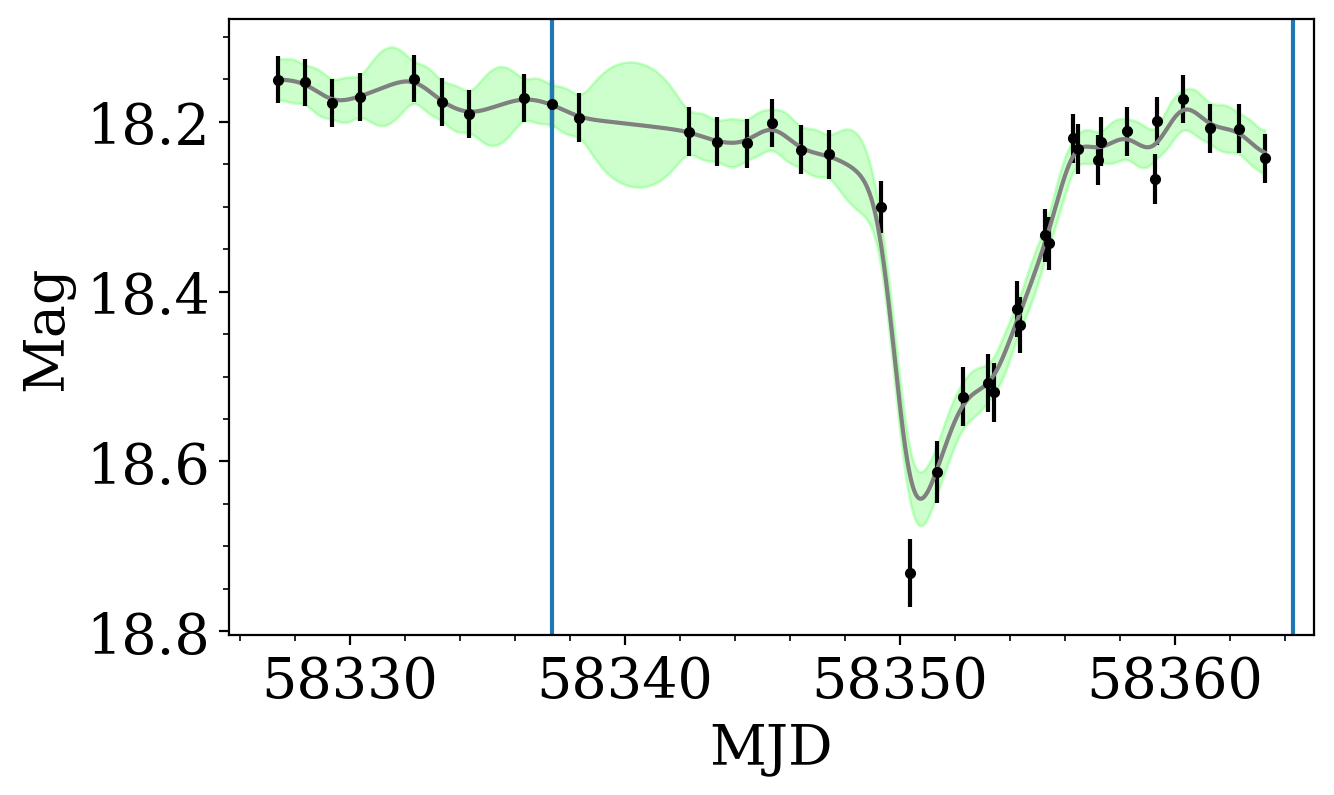

In [339]:
for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    w_i, w_e = _i['window_end'], _i['window_start']
    x_select = np.where((lc_new['mjd']>w_i-10) & (lc_new['mjd']<w_e)+10)
    
    try:

        if len(lc_new['mjd'][x_select])>0:
            gpm = gp_my_dip(lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select])

        else:
            continue

        plt.figure(figsize=(7,4))
        plt.errorbar(lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select], 
                    color='k', fmt='.')
        plt.plot(gpm[0], gpm[1], color='gray')
        plt.fill_between(gpm[0], gpm[1]-np.sqrt(gpm[2]),
                         gpm[1]+np.sqrt(gpm[2]), color='lime', alpha=0.2)

        plt.ylim(plt.ylim()[::-1])
        plt.xlabel("MJD")
        plt.ylabel("Mag")
        plt.minorticks_on()
        plt.axvline(w_i)
        plt.axvline(w_e)
    except:
        continue

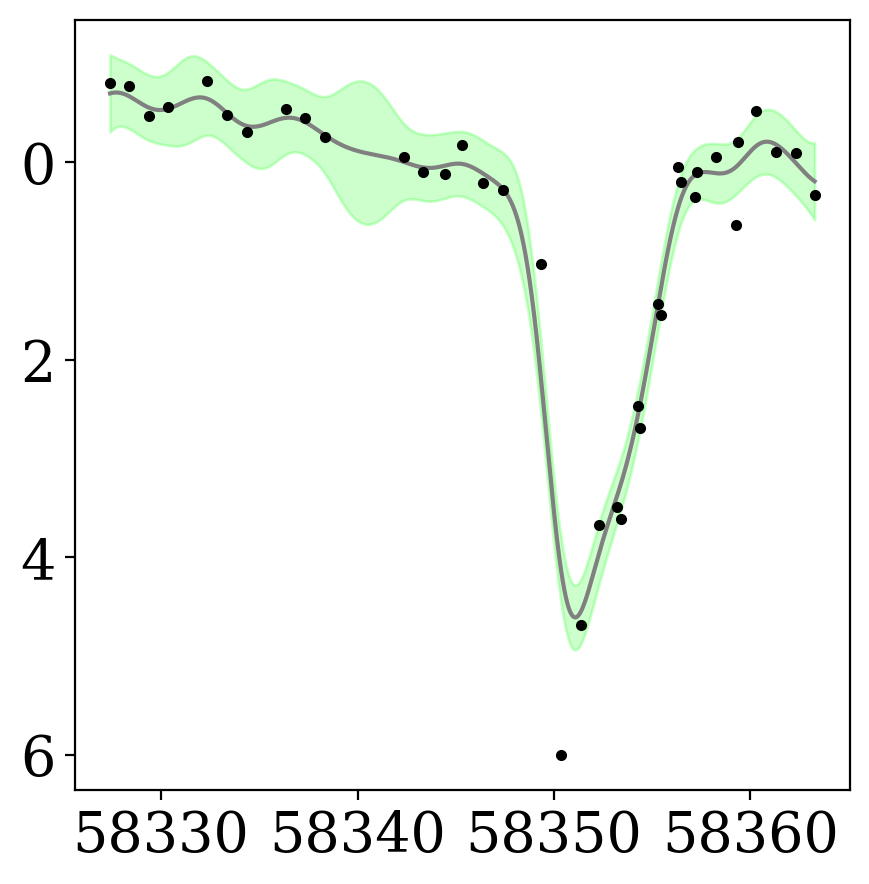

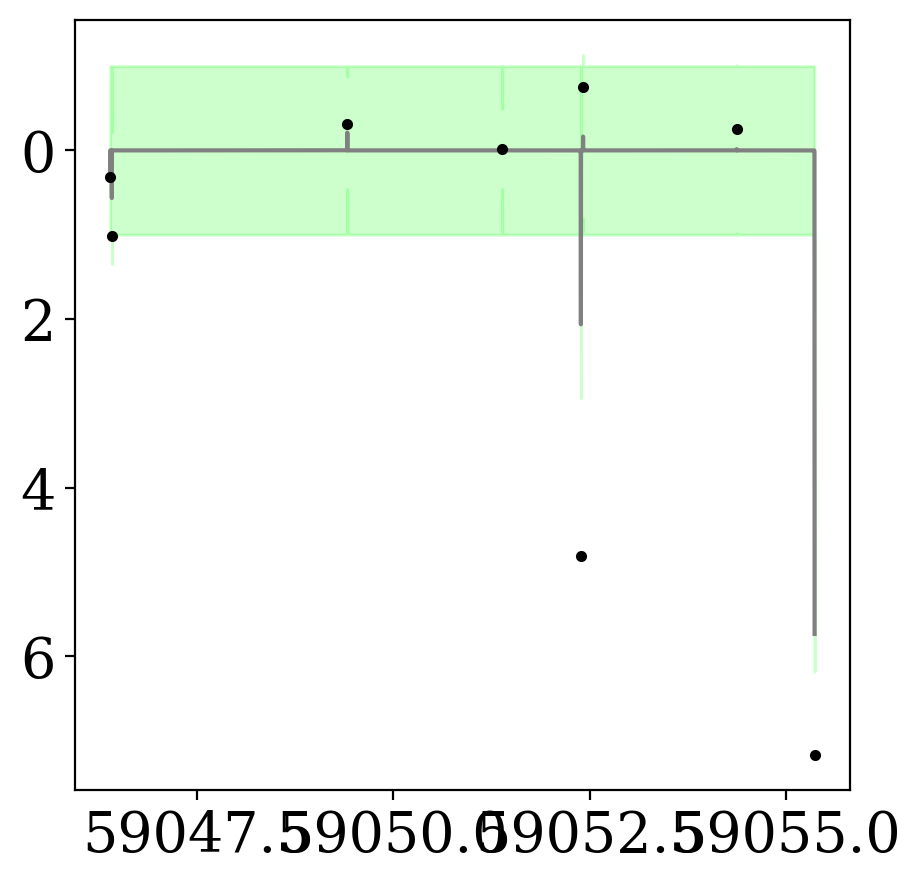

In [341]:
# tl;dr: 
# We tried running the GP fit on the deviation but we have issues with generating errors... 
# It might be okay to keep the observed R-band light curve....

for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    w_i, w_e = _i['window_end'], _i['window_start']
    x_select = np.where((lc_new['mjd']>w_i-10) & (lc_new['mjd']<w_e)+10)
    
    xdat, ydat, yerrdat = lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select]
    ydat_dev = deviation(ydat, yerrdat)
    var = 1e-6*np.sqrt(variation(ydat, yerrdat))
    
    try:

        if len(xdat)>0:
            gpm = gp_my_dip(xdat, ydat_dev, 0.5)

        else:
            continue

        plt.figure(figsize=(5,5))
        plt.errorbar(xdat, ydat_dev, var, 
                    color='k', fmt='.')
        plt.plot(gpm[0], gpm[1], color='gray')
        plt.fill_between(gpm[0], gpm[1]-np.sqrt(gpm[2]),
                         gpm[1]+np.sqrt(gpm[2]), color='lime', alpha=0.2)

        plt.ylim(plt.ylim()[::-1])
    except:
        continue

## Contextuallizing and Generallizing the GP Fits

In [342]:
lc_new = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")
inf = summarize_dev_dips(lc_new['mjd'], deviation(lc_new['mag'], lc_new['magerr']))


for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    w_i, w_e = _i['window_end'], _i['window_start']
    x_select = np.where((lc_new['mjd']>w_i-10) & (lc_new['mjd']<w_e)+10)
    
    xdat, ydat, yerrdat = lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select]
    ydat_dev = deviation(ydat, yerrdat)
    var = 1e-6*np.sqrt(variation(ydat, yerrdat))
    
    try:

        if len(xdat)>0:
            gpm = gp_my_dip(xdat, ydat, yerrdat)
            break

        else:
            continue
    except:
        continue

In [343]:
def calculate_integral(x0, y0, yerr0):
    """ Sigma (Mn - R) (Dn+1 - Dn-1)/2"""
    R = astro_stats.biweight_location(y0)
    S = astro_stats.biweight_scale(y0)
    
    integral = sum((y0[1::] - R) * (np.diff(x0)/2))
    
    integral_error = sum((yerr0[1::]**2 + S**2) * (np.diff(x0)/2)**2)
    
    return integral, np.sqrt(integral_error)

def integral_score(I_start, s_start, I_end, s_end):
    
    return ((I_start - I_end)/(np.sqrt(s_start**2 + s_end**2)))


def calc_gp_duration(gp_data, x0, y0, yerr0, diagnostic=True):
    gpx, gpy, gpyerr, _ = gp_data
    
    loc_gp = gpx[np.argmax(gpy)] # centroid of gp fit
    
    M = np.zeros(len(gpy)) + astro_stats.biweight_location(y0) # array of means
    
    # Find the indexes where the two functions intersect
    idx = np.argwhere(np.diff(np.sign(M - gpy))).flatten()
    tdx = gpx[idx] # gp times where they intersect
    tdx_phase = loc_gp - tdx # normalize wrt to peak loc
    
    # select phase
    w_pos = tdx_phase>0
    w_neg = tdx_phase<0
    
    # Select the edges of the phase
    w_end = min(tdx[w_neg])
    w_start = max(tdx[w_pos])
    
    # Select the GP area of interest
    sel_gp = np.where((gpx>=w_start) & (gpx<=w_end))
    
    # selected gaussian process curves....
    _gpx, _gpy, _gpyerr = gpx[sel_gp], gpy[sel_gp], gpyerr[sel_gp]
    _gpyerr2 = np.sqrt(_gpyerr)
    
    gp_left = _gpx <= loc_gp # left side indicies
    gp_right = _gpx >= loc_gp # right side indicies
    
    # left gp 
    left_gpx, left_gpy, left_gpyerr2 =  _gpx[gp_left], _gpy[gp_left], _gpyerr[gp_left]
    
    # right gp
    right_gpx, right_gpy, right_gpyerr2 =  _gpx[gp_right], _gpy[gp_right], _gpyerr[gp_right]
    
    
    integral_left = calculate_integral(left_gpx, left_gpy, left_gpyerr2)
    integral_right = calculate_integral(right_gpx, right_gpy, right_gpyerr2)
    
    IScore = integral_score(integral_left[0], integral_left[1], 
                           integral_right[0], integral_right[1])

    summary = {"assymetry_score": IScore, 
              "left_error": integral_left[1],
              "right_error": integral_right[1]}
    
    if diagnostic:
        # diagnostic fits
        plt.figure(figsize=(3,3))
        plt.axvline(w_start, color='red')
        plt.axvline(w_end, color='green')


        plt.scatter(gpx[idx], gpy[idx])
        plt.plot(gpx, gpy)
        plt.axhline(astro_stats.biweight_location(y0))
        plt.plot(gpx[sel_gp], gpy[sel_gp])
        plt.axvline(loc_gp, color='k', ls='--')
        plt.ylim(plt.ylim()[::-1])
        plt.errorbar(x0, y0, yerr0, color='k', fmt='.')
        plt.fill_between(_gpx, _gpy-np.sqrt(_gpyerr), _gpy+np.sqrt(_gpyerr), alpha=0.4)
        plt.title(summary)
        
    return summary
    

CPU times: user 50.3 ms, sys: 19.6 ms, total: 69.8 ms
Wall time: 41.5 ms


{'assymetry_score': 9.122580066289784,
 'left_error': 0.0037447301233371924,
 'right_error': 0.018385396056905107}

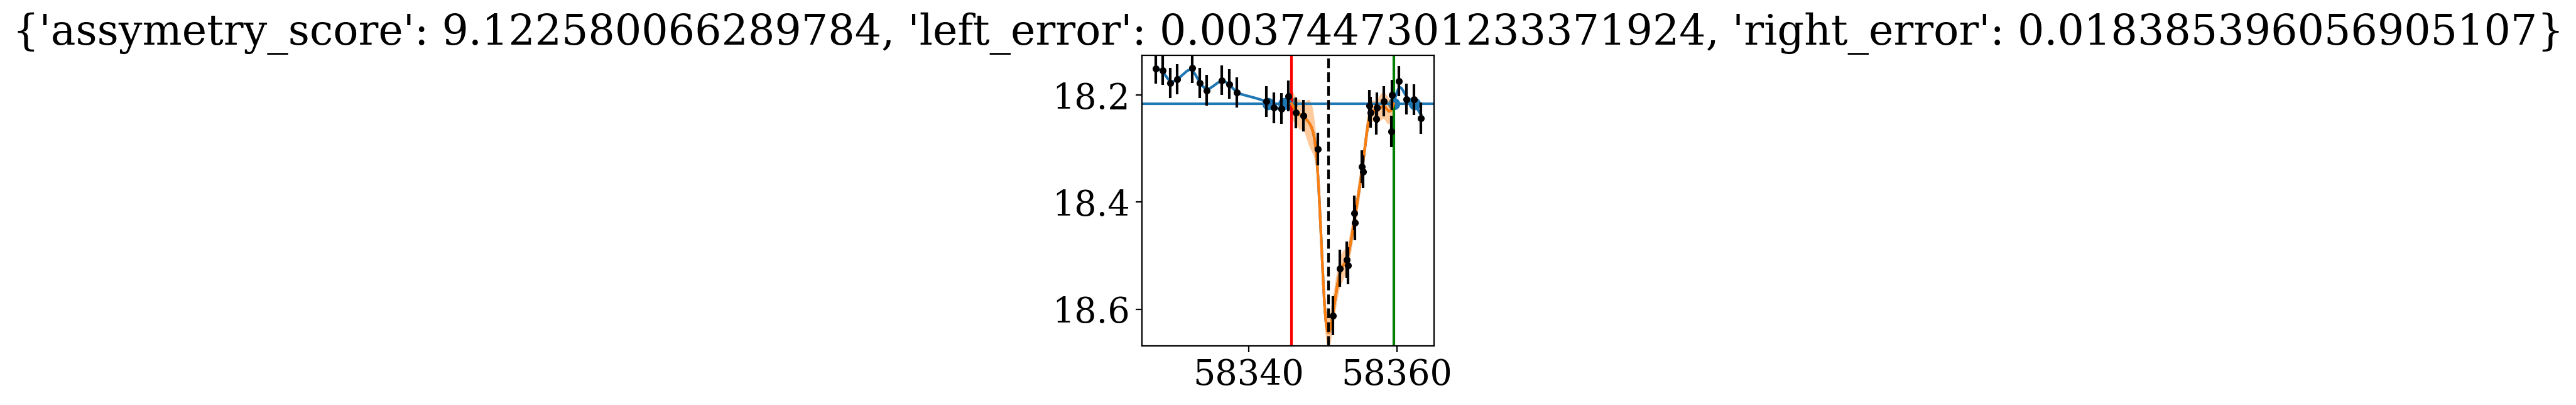

In [344]:
%%time
calc_gp_duration(gpm, xdat, ydat, yerrdat, diagnostic=True)

## Everything Together

working on dip_0


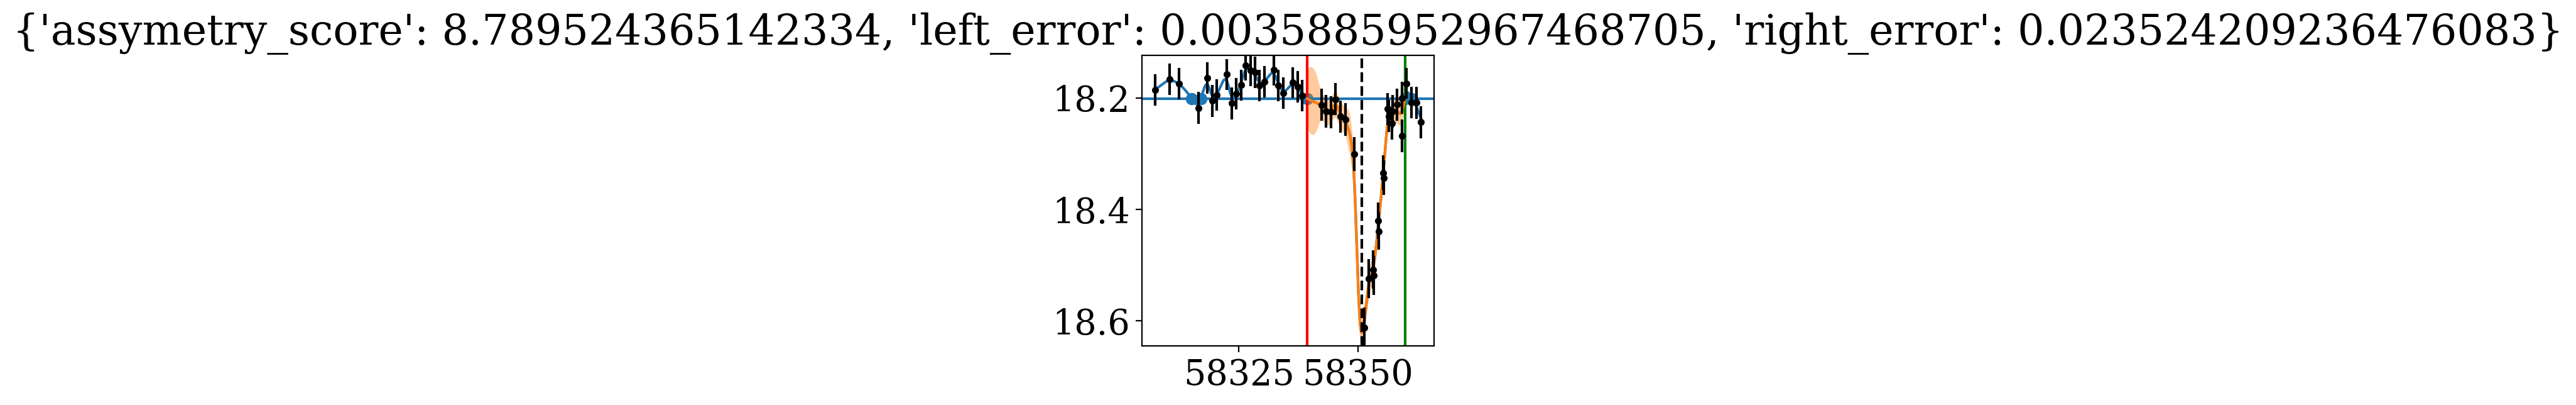

In [345]:

lc_new = ascii.read(f"https://ztf.snad.space/dr17/csv/802211300046586")


inf = summarize_dev_dips(lc_new['mjd'], deviation(lc_new['mag'], lc_new['magerr']), 
                        peak_close_rmv=25,loc_peak_thresh=6)



for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    if _i['N_1sig_in_dip']>5 and _i['loc_forward_dur']>5:


        w_i, w_e = _i['window_end'], _i['window_start']
        
        print (f"working on {k}")
    
        
        x_select = np.where((lc_new['mjd']>w_i-30) & (lc_new['mjd']<w_e)+30)
        xdat, ydat, yerrdat = lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select]




        if len(xdat)>0:
            
            gpm = gp_my_dip(lc_new['mjd'][x_select], lc_new['mag'][x_select], lc_new['magerr'][x_select])

            gp_inte = calc_gp_duration(gpm, xdat, ydat, yerrdat)
            




In [478]:
N = 15 # number of detections
time = np.random.randint(5_000-350, 5_000+350, N) + np.random.normal(0, 20, N)
ts = np.argsort(time)
time = time[ts]

line = lambda x, a, b: x*a + b
dip = lambda x, a, b, c: a*np.exp(-((x-b)**2)/(2*c**2))

mr = np.zeros(N) + 16 + np.random.normal(0, 0.001, N) + dip(time, 0.06, 5_000, 50)
mr_err = line(mr, 0.0001, 1e-3)

inf = summarize_dev_dips(time, deviation(mr, mr_err),loc_peak_thresh=6)

<ErrorbarContainer object of 3 artists>

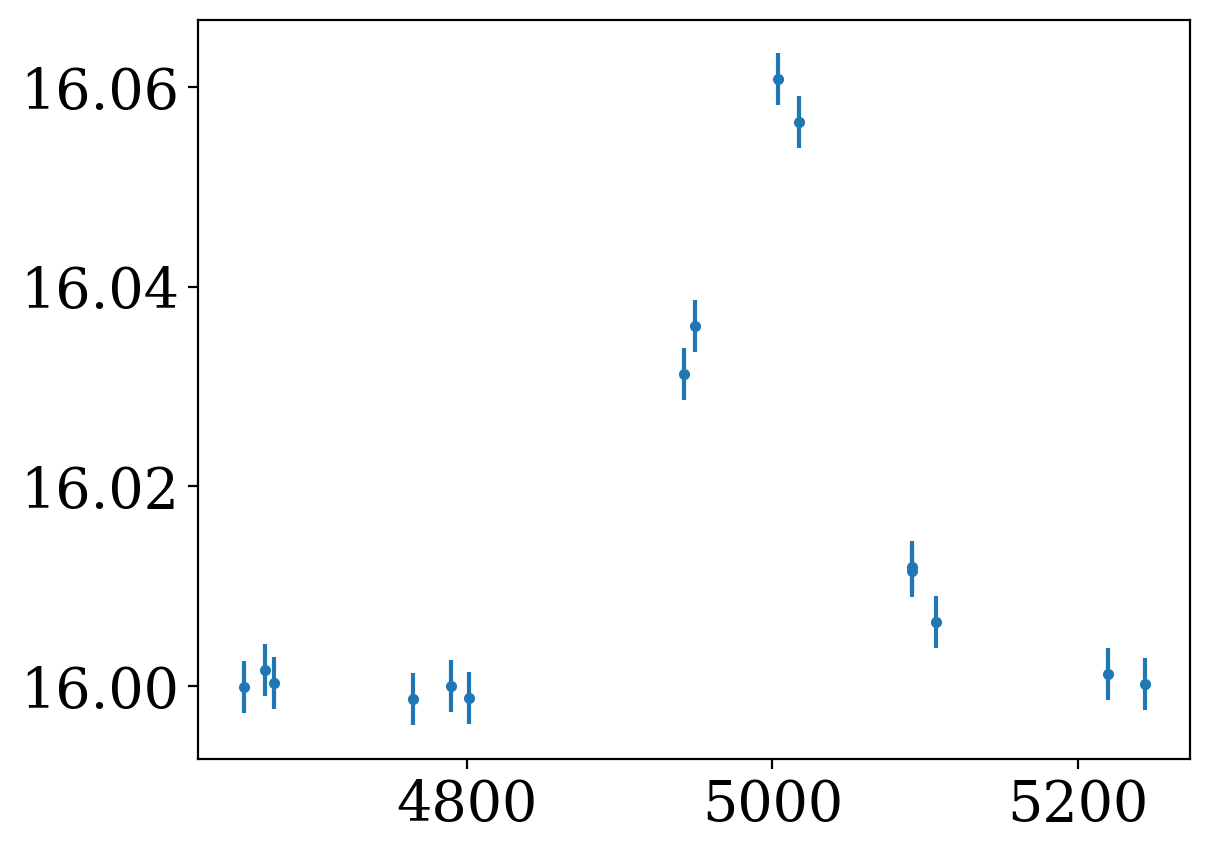

In [479]:
plt.errorbar(time, mr, mr_err, fmt='.')

In [480]:
def GaussianProcess_dip(x, y, yerr, length_scale=0.01):
    """Perform a Gaussian Process interpolation on the light curve dip.
    
    Parameters:
    -----------
    x (array-like): Time values of the light curve.
    y (array-like): Magnitude values of the light curve.
    yerr (array-like): Magnitude errors of the light curve.
    length_scale (float): Length scale of the Gaussian Process kernel. Default is 0.01.

    Returns:
    --------
    x_pred (array-like): Time values of the interpolated light curve.
    pred (array-like): Magnitude values of the interpolated light curve.
    pred_var (array-like): Magnitude variance of the interpolated light curve. (multiply by 1.96 for 1-sigma)
    summary dictionary (dict): Summary of the GP interpolation. Including initial and final log likelihoods, and the success status. TODO: femove features.
    """
    kernel = 1 * RBF(length_scale=length_scale, length_scale_bounds=(1e-2, 1e3)) + ExpSineSquared(length_scale=0.5,
    periodicity=0,
    length_scale_bounds=(1e-05, 100000.0),
    periodicity_bounds=(1e100, 1e200),) #TODO: these priors and and bounds work with current examples...
    
    noise_std = yerr
    gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=100)

    gaussian_process.fit(x.reshape(-1, 1), y)

    X = np.linspace(min(x), max(x), 2_000)

    # predict my work 
    mean_prediction, std_prediction = gaussian_process.predict(X.reshape(-1, 1), return_std=True)
    
    mean_prediction_dat, _ = gaussian_process.predict(x.reshape(-1, 1), return_std=True)
        
    return X.ravel(), mean_prediction, std_prediction, {"init_log_L": 0, 
                                "final_log_L": 0, 
                                "success_status": True, 
                                'chi-square': np.sum((y-mean_prediction_dat)**2/yerr**2)}

In [481]:
gp = GaussianProcess_dip(time, mr, mr_err)

/Users/andytzanidakis/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/andytzanidakis/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [482]:
gp

(array([4654.00945986, 4654.30455151, 4654.59964317, ..., 5243.30749967,
        5243.60259133, 5243.89768299]),
 array([16.00076891, 16.00074917, 16.00072978, ..., 16.00055206,
        16.00040672, 16.00025703]),
 array([0.0025004 , 0.00244568, 0.0023924 , ..., 0.00250725, 0.00254847,
        0.00259116]),
 {'init_log_L': 0,
  'final_log_L': 0,
  'success_status': True,
  'chi-square': 9.018825725829846})

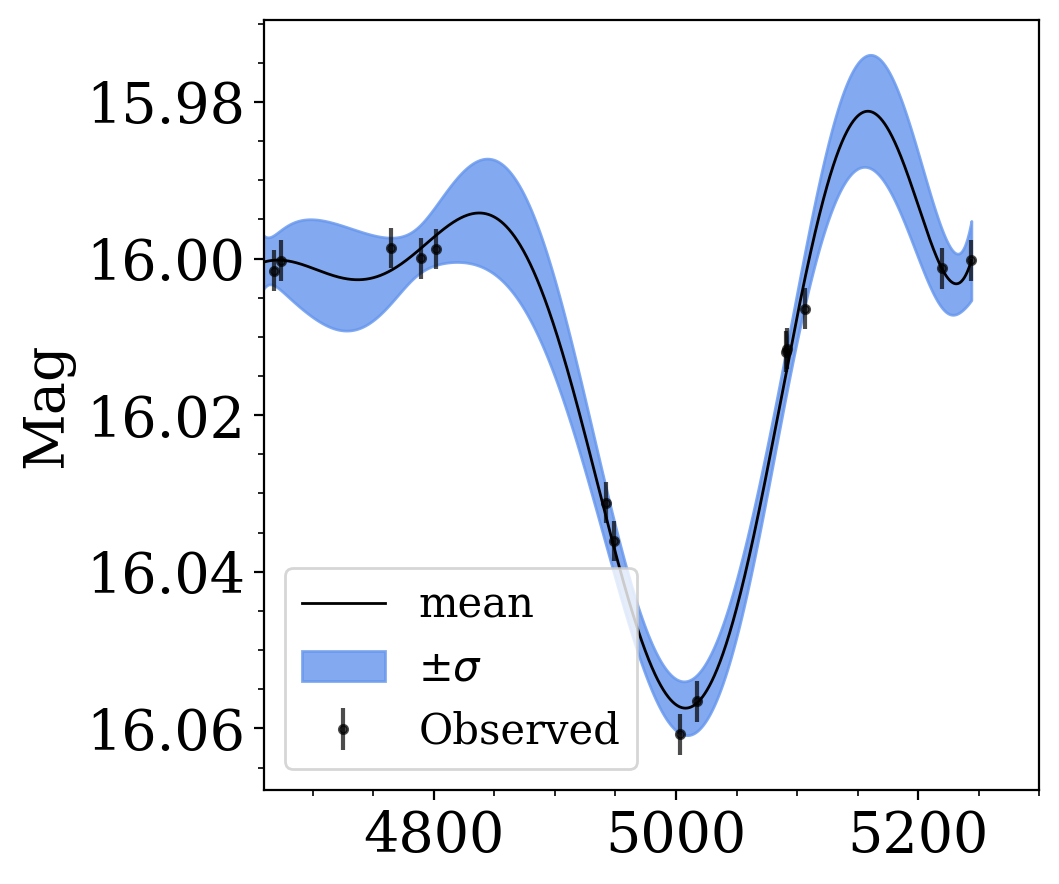

In [483]:
plt.figure(figsize=(5,5))
plt.plot(gp[0], gp[1], lw=1, color='k', 
        label='mean')
plt.fill_between(gp[0], gp[1]-1.95*gp[2], gp[1]+1.95*gp[2], color='CornFlowerBlue', alpha=0.8, 
                label='$\pm \sigma$')
plt.errorbar(time, mr, yerr=mr_err, fmt='.', alpha=0.7, color='k', 
            label='Observed')
plt.ylim(plt.ylim()[::-1])
plt.xlim(5_000-340, 5_000+300)
plt.minorticks_on()
plt.ylabel("MJD")
plt.ylabel("Mag")
plt.legend(fontsize=15)

working on dip_0


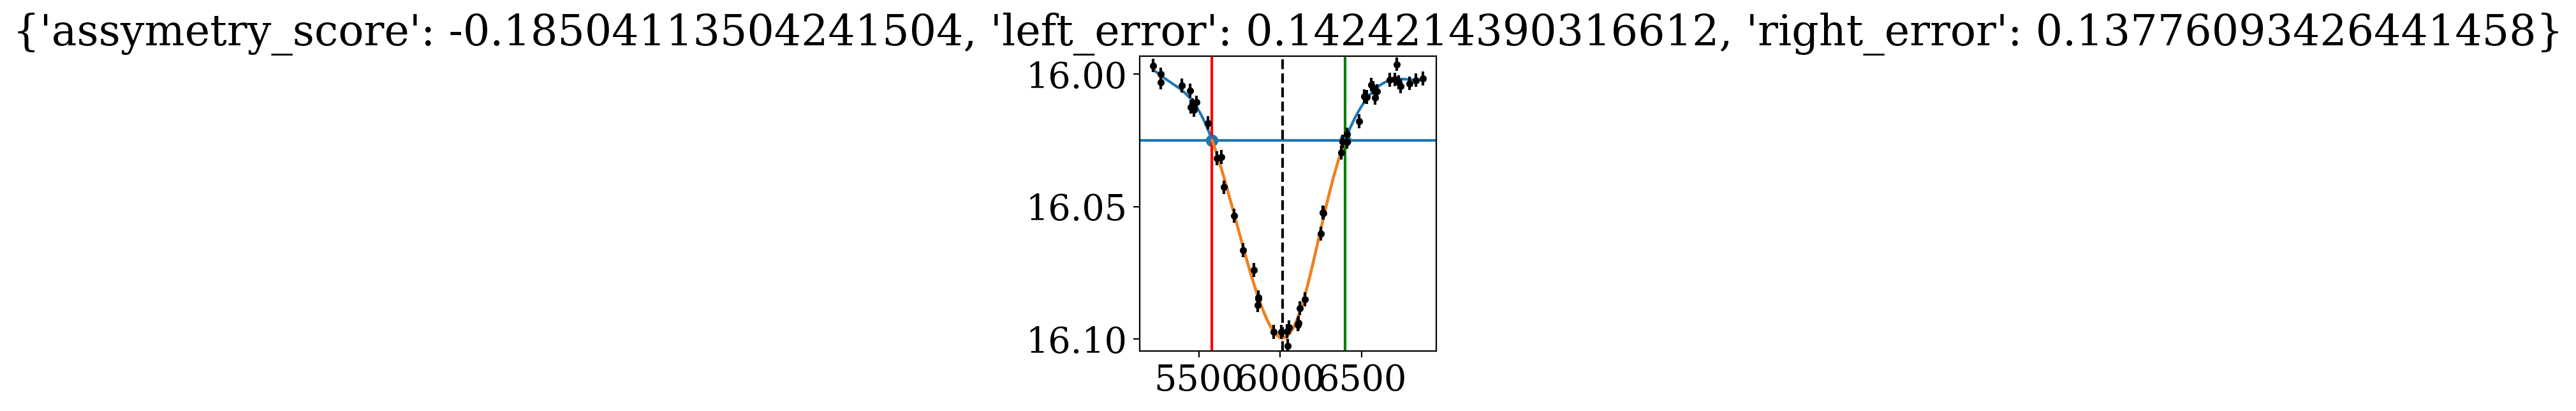

In [354]:

for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    if _i['N_1sig_in_dip']>5 and _i['loc_forward_dur']>100:


        w_i, w_e = _i['window_end'], _i['window_start']
        
        print (f"working on {k}")
    
        
        x_select = np.where((time>w_i-60) & (time<w_e)+60)
        xdat, ydat, yerrdat = time[x_select], mr[x_select], mr_err[x_select]




        if len(xdat)>0:
            
            gpm = gp_my_dip(xdat, ydat, yerrdat)

            gp_inte = calc_gp_duration(gpm, xdat, ydat, yerrdat)
            


In [355]:
yha = savgol_filter( deviation(mr, mr_err), 11, 8)

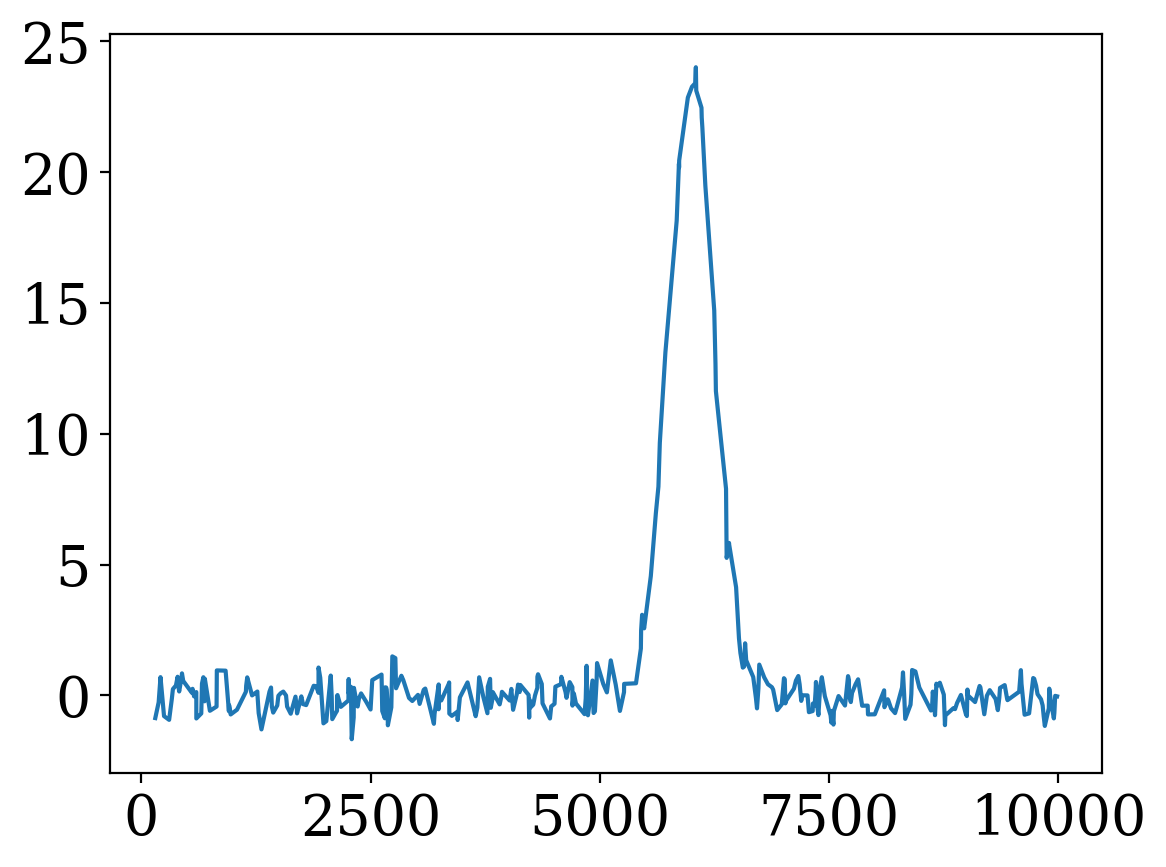

In [356]:
plt.plot(time, yha)